In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [221]:
data_frame = pd.read_csv("./data/mnist_train.csv", sep=",", header=None)

In [222]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [223]:
data_frame.loc[:, 1:] /= 255.0

In [224]:
data=data_frame.as_matrix()

C:\Users\Paulina\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [225]:
image=data[0,1:].reshape((28,28))
data[0,0]

5.0

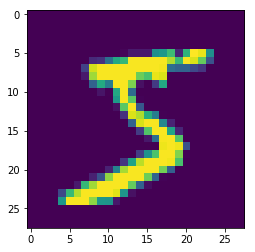

In [226]:
plt.imshow(image)
plt.show()

## Data split

In [12]:
#create validation set
np.random.shuffle(data)
train_data=data[0:50000,:]
val_data=data[50000:,:]


## Data augmentation

In [230]:
import skimage as sk
from skimage import transform
import random
import scipy
from random import randint

## original image

In [362]:
image = train_data[0,1:]

In [237]:
def rotation (x):
    image=x.reshape(28,28)
    random_degree = random.uniform(-40, 40)
    rotated=sk.transform.rotate(image, random_degree)
    return rotated.reshape(1,784)    

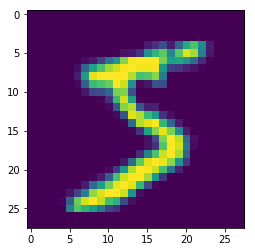

In [238]:
image=data[0,1:]
rotated = rotation(image)
image_rotated=rotated.reshape(28,28)
plt.imshow(image_rotated)
plt.show()

In [239]:
#blurriness and translation
def blurriness_translation (x):
    vector=np.array((random.uniform(-5,5), random.uniform(-5,5)))
    blurrness_ratio=randint(0,5)
    transformed=scipy.ndimage.shift(data[0,1:].reshape(28,28), vector,order=blurrness_ratio,mode='constant')
    return transformed.reshape(1,784)

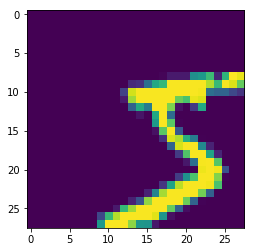

In [240]:
transformed = blurriness_translation(image)
image_transformed=transformed.reshape(28,28)
plt.imshow(image_transformed)
plt.show()

In [333]:
#rescale
def rescale (x):
    x=x.reshape(28,28)
    scale=random.uniform(5,9)/10
    rescaled1=sk.transform.rescale(x, scale, mode='constant', multichannel=False)
    padding_shape=int(np.floor((1-scale)*28/2)+1)
    rescaled_with_padding=np.pad(rescaled1,(padding_shape,padding_shape),mode='constant', constant_values=0)
    transformed=rescaled_with_padding[:28,:28]
    return transformed

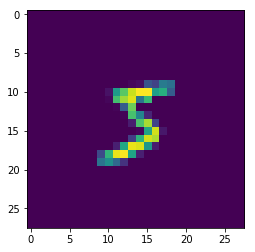

In [334]:
rescaled= rescale(image)
plt.imshow(rescaled)
plt.show()

In [325]:
#ZCA whitening
#https://stackoverflow.com/questions/31528800/how-to-implement-zca-whitening-python


def zca_whitening(x):
    x=x.reshape(1,784)
    sigma = np.dot(x, x.T)/x.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)              #ZCA Whitening matrix
    return np.dot(ZCAMatrix, x)   #Data whitening

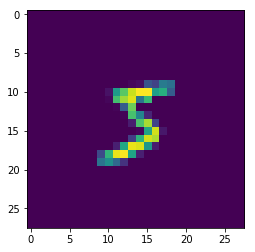

In [337]:
whitened= zca_whitening(image)
plt.imshow(rescaled)
plt.show()

In [360]:
def random_noise (x):
    noise = np.random.normal(0.0, 0.05, 784) 
    return x+noise

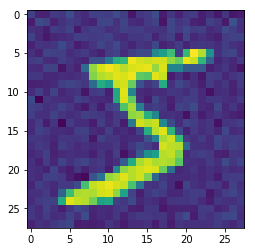

In [361]:
noisy= random_noise(image)
plt.imshow(noisy.reshape(28,28))
plt.show()

In [451]:
#applying modifications to some images
image_transformations = {
    0: rotation,
    1: random_noise,
    2: blurriness_translation,
    3: zca_whitening,
    4: rescale   
}


for i in range(1000):
    # random num of transformations to apply
    to_apply=np.random.randint(0,2,len(image_transformations))
    input_image=train_data[i,1:]
    for i in range (len(image_transformations)):
        if to_apply[i]==1:
            input_image=image_transformations[i](input_image) 
            input_image=input_image.reshape(1,784)
    modified=np.insert(input_image, -1,np.array(train_data[i,0]))
    modified=modified.reshape(1,785)
    train_data=np.append(train_data, modified,axis=0)   



<function random_noise at 0x0000025402801048>


In [452]:
train_data.shape

(61001, 785)

# Funkcje aktywacji wraz z ich pochodnymi

In [453]:
def sigmoid_function(x):
    return 1 / (1 + np.exp(-x))

def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

def softmax_derivative(probabilities, layer_inputs):
    number_of_classes = probabilities.shape[0]
    diff_output = np.zeros([number_of_classes, number_of_classes])
    for row in range(diff_output.shape[0]):
        for col in range(diff_output.shape[1]):
            if (col == row):
                diff_output[row, col] = probabilities[row, 0] * (1 - probabilities[col, 0])
            else:
                diff_output[row, col] = -probabilities[row, 0] * probabilities[col, 0]
    return np.matmul(diff_output, layer_inputs)

def sigmoid_derivative(u):
    sigmoid_value = sigmoid_function(u)
    diff_output = sigmoid_value * (1 - sigmoid_value)
    return diff_output

def tanh_derivative(u):
    tanh_value = tanh_function(u)
    diff_output = 1 - np.power(tanh_value, 2)
    return diff_output

def tanh_function(x):
    return np.tanh(x)

# Implementacja sieci neuronowej

In [582]:
def cross_entropy (out, label):
    cost = -np.mean(label*np.log(out+1e-9))
    return cost

In [766]:
import numpy as np
from random import shuffle
from sklearn.metrics import mean_squared_error

class Network(object):
    
    @staticmethod
    def get_activation_functions_with_deriv():
        return {
            "sigmoid": [sigmoid_function, sigmoid_derivative],
            "tanh": [tanh_function, tanh_derivative],
            "relu": [relu_function, relu_derivative]
        }
    
    @staticmethod
    def get_error_functions():
        return {
            "mse": lambda out, lab: mean_squared_error(out, lab),
            "cross_entropy": lambda out, lab: cross_entropy(out, lab) 
        }
    @staticmethod
    def get_cost_functions():
        return {
            "mse": lambda outputs, inputs, labels, deriv: (outputs - labels) * \
                                                           deriv(outputs, inputs),
            "cross_entropy": lambda outputs, inputs, labels, deriv: outputs - labels
        }
    
    def __init__(self,
                 input_neurons_num,
                 hidden_layer_neurons_num,
                 hidden_activation_functions_names,
                 learning_rate=0.04, weight_decay=0.005, momentum=0.9,
                 error_function_name="cross_entropy", regularization=False, momentum_presence=False):
        self.input_neurons_num = input_neurons_num
        self.number_of_classes = 10
        self.learning_rate = learning_rate
        self.weight_decay=weight_decay
        self.momentum=momentum
        self.regularization=regularization
        self.momentum_presence=momentum_presence
        self.neurons_num_per_layer = [self.input_neurons_num] + hidden_layer_neurons_num + [self.number_of_classes]
        self.layers_num = len(self.neurons_num_per_layer)
        self.activation_functions = self.__get_activation_functions(hidden_activation_functions_names)
        self.activation_deriv_functions = self.__get_deriv_activation_functions(hidden_activation_functions_names)
        self.error_function = Network.get_error_functions()[error_function_name]
        self.cost_function = Network.get_cost_functions()[error_function_name]
        self.weight_list = Network.__get_weight_list(self.neurons_num_per_layer)
        self.bias_list = Network.__get_bias_list(self.neurons_num_per_layer)
    

    def __get_deriv_activation_functions(self, inner_activation_functions_names):
        functions = Network.__transform_to_activation_func_with_deriv(inner_activation_functions_names)
        return list(map(lambda x: x[1], functions)) + \
            [lambda prob, layer_inputs: softmax_derivative(probabilities=prob, layer_inputs=layer_inputs)]
    
    def __get_activation_functions(self, inner_activation_functions_names):
        functions = Network.__transform_to_activation_func_with_deriv(inner_activation_functions_names)
        return list(map(lambda x: x[0], functions)) + \
            [lambda x: softmax_function(x)]
    
    @staticmethod
    def __transform_to_activation_func_with_deriv(inner_activation_functions_names):
        functions = Network.get_activation_functions_with_deriv()
        return map(lambda name: functions[name], inner_activation_functions_names)
        
    @staticmethod
    def __get_bias_list(neurons_num_per_layer):
        return [np.random.randn(layer_num, 1) for layer_num in neurons_num_per_layer[1:]]

    @staticmethod
    def __get_weight_list(neurons_num_per_layer):
        # Xavier initialization
        return [np.random.randn(next_layer_num, current_layer_num) *
                np.sqrt(1 / (next_layer_num + current_layer_num))
                for (current_layer_num, next_layer_num) in zip(neurons_num_per_layer, neurons_num_per_layer[1:])]
    

    def train(self, train_data, val_data, train_batch_size, epochs):
        train_avg_per_epoch = np.zeros(epochs)
        val_avg_per_epoch = np.zeros(epochs)
        for epoch in range(epochs):
            np.random.shuffle(train_data)
            train_batches = Network.__create_batches(train_data, train_batch_size)
            train_cost = self.__train_one_epoch(train_batches)
            train_avg_per_epoch[epoch] = train_cost / train_data.shape[0]
            _, val_cost = self.predict(val_data)
            val_avg_per_epoch[epoch] = val_cost / val_data.shape[0]
            
            if val_avg_per_epoch[epoch]>3*val_avg_per_epoch[epoch-1]:
                break
                #powinnyśmy dodać mechanizm powrotu do stanu z poprzedniej epoki
                
        return train_avg_per_epoch, val_avg_per_epoch

    def predict(self, test_data):
        labels = Network.one_hot_encoded(test_data[:, 0], self.number_of_classes)
        features = test_data[:, 1:]
        res = []
        diff = 0
        stat = np.zeros((test_data.shape[0], 2))
        for i in range(len(test_data)):
            _, layer_output_list = self.__feed_forward(features[i, :])
            output = layer_output_list[-1]
            stat[i, 0] = np.argmax(output)
            stat[i, 1] = np.argmax(labels[:, i])    
            diff += self.error_function(output, labels[:, i])
        return stat, diff
    
    def __train_one_epoch(self, train_batches):
        full_cost = 0
        grad_w_prev = [0] * (self.layers_num - 1)
        grad_b_prev = [0] * (self.layers_num - 1)
        for train_batch in train_batches:
            labels = Network.one_hot_encoded(train_batch[:, 0], self.number_of_classes)
            train_batch_features = train_batch[:, 1:]
            batch_size = train_batch_features.shape[0]
            grad_b, grad_w, cost = self.__get_gradients(labels, train_batch, train_batch_features)
            full_cost += cost
            self.__update_network_params(batch_size, grad_b, grad_w, grad_w_prev)
            grad_w_prev=grad_w
        return full_cost

    def __update_network_params(self, batch_size, grad_b, grad_w,grad_w_prev):
        if (self.momentum_presence==True):
                momentum_term_w = [ self.momentum*w_prev/self.learning_rate for w_prev in grad_w_prev]
                grad_w=[a+b for a, b in zip(grad_w,momentum_term_w)]
                #specjalnie nie ma tu analogicznych wzorów dla bias
            
        self.weight_list = [w - (self.learning_rate * gw / batch_size)
                            for w, gw in zip(self.weight_list, grad_w)]
        self.bias_list = [b - (self.learning_rate * gb / batch_size)
                          for b, gb in zip(self.bias_list, grad_b)]

    def __get_gradients(self, labels, train_batch, train_batch_features):
        cost = 0
        grad_w = [0] * (self.layers_num - 1)
        grad_b = [0] * (self.layers_num - 1)
        for i in range(len(train_batch)):  # rekord
            layer_inputs, layer_outputs = self.__feed_forward(train_batch_features[i, :])
            cost += self.error_function(layer_outputs[-1], labels[:, i].reshape(self.number_of_classes, -1))
           
            # backprop
            delta = self.__get_deltas(labels[:, i], layer_inputs, layer_outputs)
            one_grad_w = [np.matmul(delta[0], train_batch_features[i, :].reshape(self.input_neurons_num, -1).T)]
            for activ, d, u in zip(self.activation_functions, delta[1:], layer_inputs):
                one_grad_w.append(np.matmul(d, activ(u).T))
                
                
            grad_w = [a + b for a, b in zip(grad_w, one_grad_w)]
            grad_b = [a + b for a, b in zip(delta, grad_b)]
            
            if (self.regularization==True):
                regularization_term = [ self.weight_decay*w for w in self.weight_list]
                grad_w=[a+b for a, b in zip(grad_w,regularization_term)]
                
        return grad_b, grad_w, cost

    def __get_deltas(self, labels, layer_inputs, layer_outputs):
        labels = labels.reshape(self.number_of_classes, -1)
        delta = [self.cost_function(layer_outputs[-1],
                                    layer_inputs[-1],
                                    labels, 
                                    self.activation_deriv_functions[-1])]
        for layer_num in reversed(range(1, self.layers_num - 1)):
            delta.append(np.matmul(self.weight_list[layer_num].T, delta[-1]) *
                         self.activation_deriv_functions[layer_num - 1](layer_inputs[layer_num - 1]))
        delta = list(reversed(delta))
        return delta

    def __feed_forward(self, features):
        layer_inputs = []
        layer_output = [features]
        for activation_function, w, b in zip(self.activation_functions,
                                             self.weight_list,
                                             self.bias_list):
            a = np.matmul(w, layer_output[-1])
            layer_inputs.append(a.reshape(a.shape[0], 1) + b)
            layer_output.append(activation_function(layer_inputs[-1]))
        return layer_inputs, layer_output

    @staticmethod
    def __create_batches(data, batch_size):
        rows_num = data.shape[0]
        n = int(np.ceil(rows_num / batch_size))
        return [data[(i * batch_size):min((i + 1) * batch_size, rows_num)] for i in range(n)]

    @staticmethod
    def one_hot_encoded(labels, number_of_classes):
        labels = labels.astype(int)
        res = np.zeros((number_of_classes, labels.shape[0]))
        res[labels, np.arange(res.shape[1])] = 1
        return res

# Testowanie modelu

In [868]:
net = Network(input_neurons_num=784,
              hidden_layer_neurons_num=[128]*2,
              hidden_activation_functions_names=["tanh"] * 2)

In [869]:
train_mse,val_mse = net.train(train_data, val_data, train_batch_size=128, epochs=25)

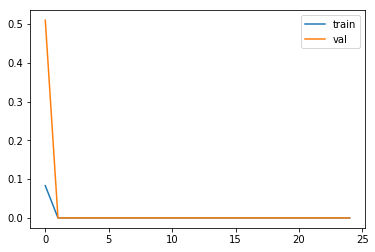

In [870]:
import matplotlib.pyplot as plt
plt.plot(train_mse, label = "train")
plt.plot(val_mse, label = "val")
plt.legend(loc = "upper right")
plt.show()

## Accuracy analysis

In [871]:
stat, _=net.predict(val_data)

In [872]:
def compute_accurracy(stat):
    count=0
    for i in range (stat.shape[0]):
        if stat[i,0]==stat[i,1]:
            count=count+1
    return count/stat.shape[0]

In [873]:
val_accuracy = compute_accurracy(stat)
print("val_accuracy: {0}".format(val_accuracy))

val_accuracy: 0.8763


In [874]:
data_test = pd.read_csv("./data/mnist_test.csv", sep=",", header=None)
data_frame.loc[:, 1:] /= 255.0
data1=data_test.as_matrix()

FileNotFoundError: File b'./data/mnist_test.csv' does not exist

In [875]:
stat, _=net.predict(data1)

In [876]:
test_accuracy = compute_accurracy(stat)
print("test_accuracy: {0}".format(test_accuracy))

test_accuracy: 0.7007


## ROC curve

In [ ]:
def one_hot_encoded(labels, number_of_classes):
    labels = labels.astype(int)
    res = np.zeros((number_of_classes, labels.shape[0]))
    res[labels, np.arange(res.shape[1])] = 1
    return res

In [714]:
predictions=one_hot_encoded(stat[:,0],10).T
labels=one_hot_encoded(stat[:,1],10).T
from sklearn.metrics import roc_curve, auc
false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()
for i in range(10):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(predictions[:, i], labels[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

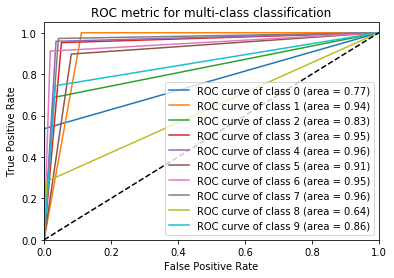

In [653]:
#wykres zbiorczy

#TODO: DODAĆ NA WYKRESIE INFO KTÓREJ KATEGORII ON DOTYCZY
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC metric for multi-class classification')
plt.legend(loc="lower right")
plt.show()

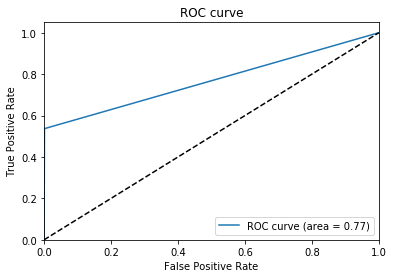

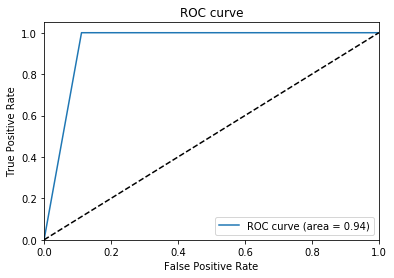

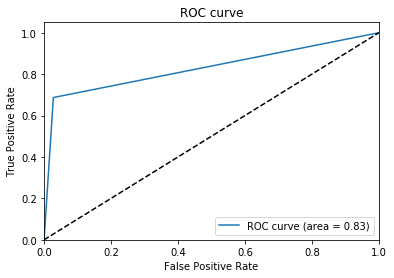

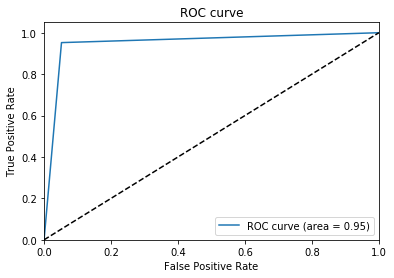

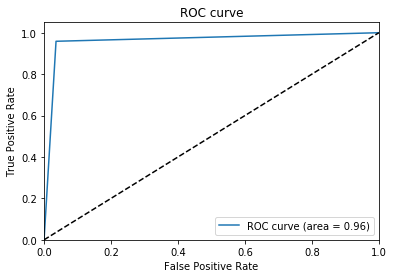

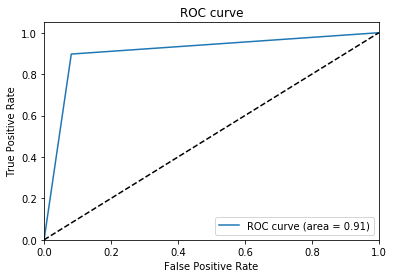

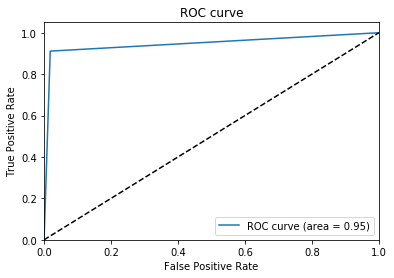

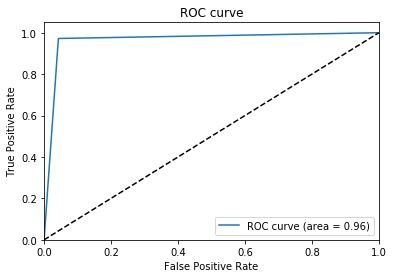

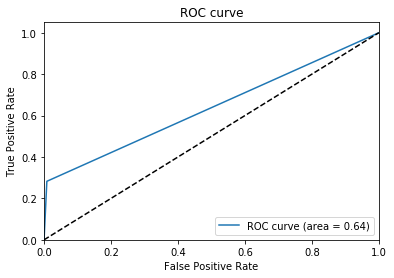

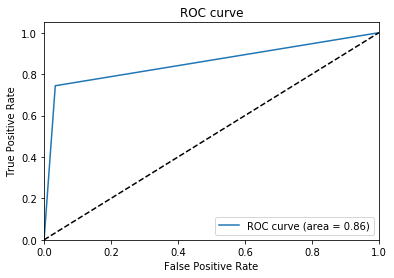

In [654]:
# wykres dla każdej z kategorii
for i in range(10):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
plt.show()

## Confusion Matrix

In [785]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(stat[:,1], stat[:,0])
print(conf_matrix)

[[952   0   8   4   0   0   2   0  14   0]
 [  0 723   7  66   0   0   2   0 337   0]
 [ 20   0 895  35   6   0   7   4  62   3]
 [  4   0  27 929   1   0   2   3  37   7]
 [  7   0  26  16 600   0   2   0  92 239]
 [ 91   1  12 193   1 225  11   2 350   6]
 [ 50   0  83   2  11   1 782   0  28   1]
 [ 16   0  77  64   4   0   0 720  36 111]
 [ 12   0  12  32   1   0   5   2 907   3]
 [ 12   2   7  47   6   0   0   2 113 820]]
